# Advanced Lane Finding

**Udacity - Self-Driving Car NanoDegree**

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply the distortion correction to the raw image.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find lane boundary.
6. Determine curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob

# Step 1 -- camera calibration

In [2]:
nx, ny = 9, 6

# Prepare object/image points storages
objpoints, imgpoints = [], []

# Prepare object points values
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

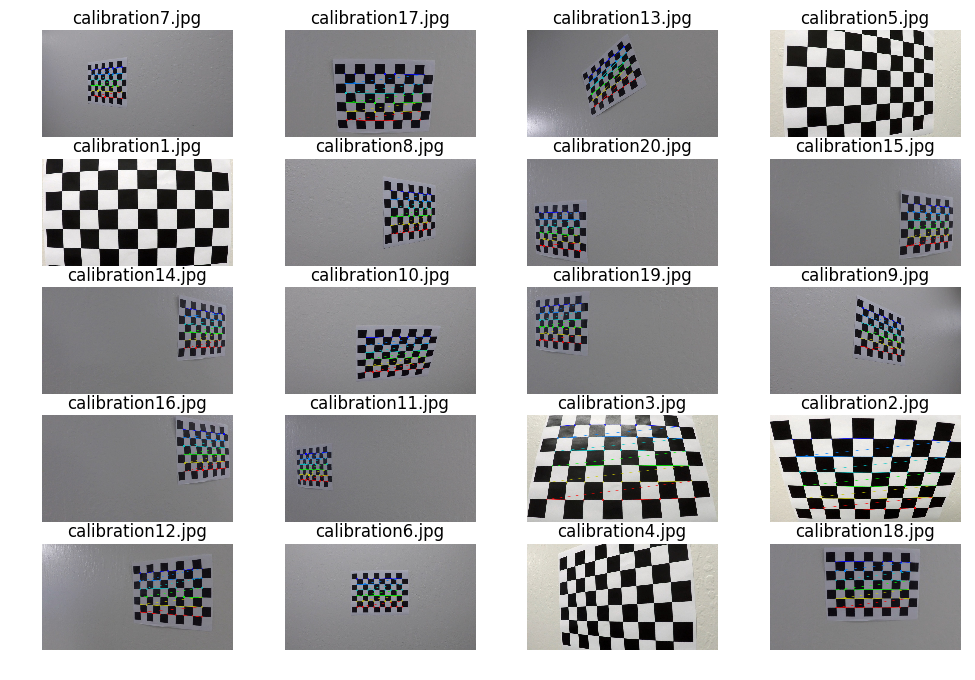

In [3]:
i = 0
imgsx, imgsy = 5, 4
f, axarr = plt.subplots(imgsx, imgsy, figsize=(12,8))

# Find chessboard corners and draw them
for f in glob.glob('camera_cal/calibration*.jpg'):
    
    # Read and find
    img = mpimg.imread(f)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
    
    # Store points if corners are found
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

    # Visualize
    axarr[i // imgsy][i % imgsy].set_title(f[f.find('calibration'):])
    axarr[i // imgsy][i % imgsy].imshow(img)
    axarr[i // imgsy][i % imgsy].axis('off')
    i += 1
plt.show()

In [4]:
assert len(imgpoints) == len(objpoints)
len(imgpoints)

17

As we can see, 3 images have not recognized chessboard since they are not fully visible on the image.

17 is enough for calibration though

In [5]:
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)

def get_undistorted_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Step 2 -- get undistorted image

Let's try just prepared function `get_undistorted_image` and see the difference

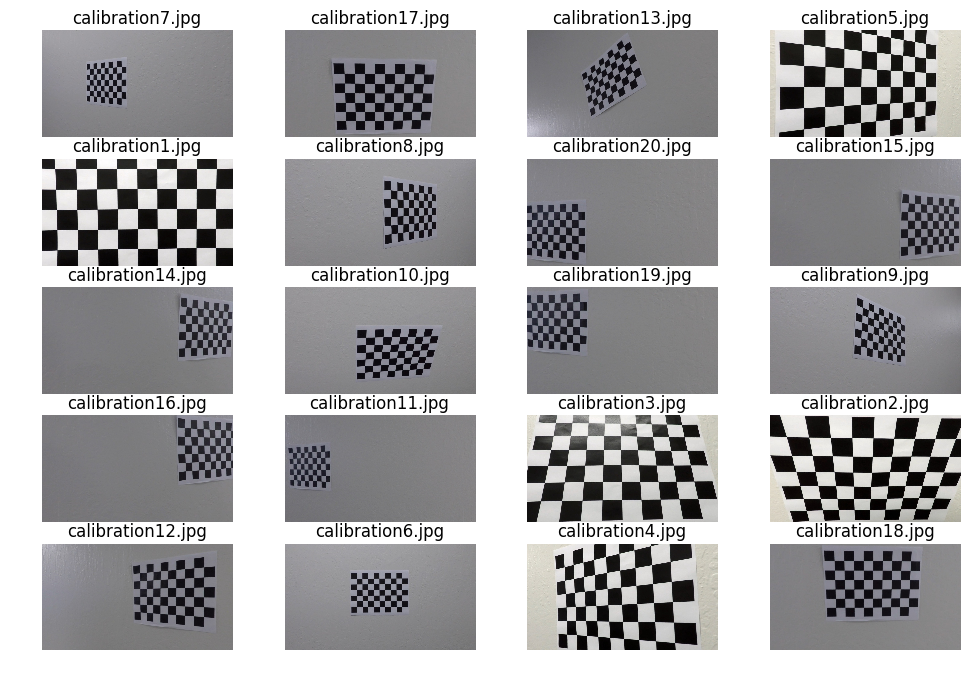

In [6]:
i = 0
imgsx, imgsy = 5, 4
f, axarr = plt.subplots(imgsx, imgsy, figsize=(12,8))

# Draw undistortion examples
for f in glob.glob('camera_cal/calibration*.jpg'):
    img = mpimg.imread(f)
    img = get_undistorted_image(img)
    axarr[i // imgsy][i % imgsy].set_title(f[f.find('calibration'):])
    axarr[i // imgsy][i % imgsy].imshow(img)
    axarr[i // imgsy][i % imgsy].axis('off')
    i += 1
plt.show()

As we can see (especially in calibration 1-5), undistorted images look much better so we can use `get_undistorted_image` as part of the pipeline

# Step 3 -- get thresholded binary image

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [8]:
def get_thresholded_binary_image(image_rgb, get_all_masks=False):
    # Choose a Sobel kernel size
    ksize = 17
    
    # Get grayscale and HLS channels from initial RGB image
    hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Get all thresholds for GRAY image
    gradxy_thresh = (15, 200)
    gradx_gray = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=gradxy_thresh)
    grady_gray = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=gradxy_thresh)
    mag_gray = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 200))
    
    # Get all thesholds for S-channel of HLS image
    gradxy_thresh = (60, 200)
    gradx_s = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=gradxy_thresh)
    grady_s = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=gradxy_thresh)
    mag_s = mag_thresh(s_channel, sobel_kernel=ksize, mag_thresh=(50, 200))
    
    # Combine masks together
    gradxy_gray = np.zeros_like(gray)
    gradxy_gray[(gradx_gray == 1) & (grady_gray == 1)] = 1    
    gradxy_s = np.zeros_like(gray)
    # gradxy_s[(gradx_s == 1) & (grady_s == 1)] = 1
    gradxy_s[(grady_s == 1)] = 1
    
    magdir_gray = np.zeros_like(gray)
    magdir_gray[(mag_gray == 1)] = 1
    magdir_s = np.zeros_like(gray)
    magdir_s[(mag_s == 1)] = 1
    
    sonly = np.zeros_like(gray)
    sonly[(s_channel >= 170)] = 1
    
    # Lightness-based
    lonly = np.zeros_like(gray)
    lonly[l_channel >= 170] = 1
    
    # Lightness and magdir_gray
    l_magdir_gray = np.zeros_like(gray)
    l_magdir_gray[(lonly == 1) & (magdir_gray == 1)] = 1

    # Lightness and magdir_s
    l_magdir_s = np.zeros_like(gray)
    l_magdir_s[(lonly == 1) & (magdir_s == 1)] = 1
    
    # Hue-based only (yellow range)
    honly_yellow = np.zeros_like(gray)
    honly_yellow[(h_channel >= 12) & (h_channel <= 30)] = 1
    
    # Hue + magdir_s
    h_magdir_s = np.zeros_like(gray)
    h_magdir_s[(honly_yellow == 1) & (magdir_s == 1)] = 1
    
    # Hue + magdir_gray
    h_magdir_gray = np.zeros_like(gray)
    h_magdir_gray[(honly_yellow == 1) & (magdir_gray == 1)] = 1

    # Combine them
    combined = np.zeros_like(gray)
    combined[(l_magdir_gray == 1) | (h_magdir_s == 1)] = 1
    
    if get_all_masks:
        return combined, lonly, honly_yellow, magdir_gray, l_magdir_gray, magdir_s, h_magdir_s, l_magdir_s, h_magdir_gray
    return combined

(-0.5, 1279.5, 719.5, -0.5)

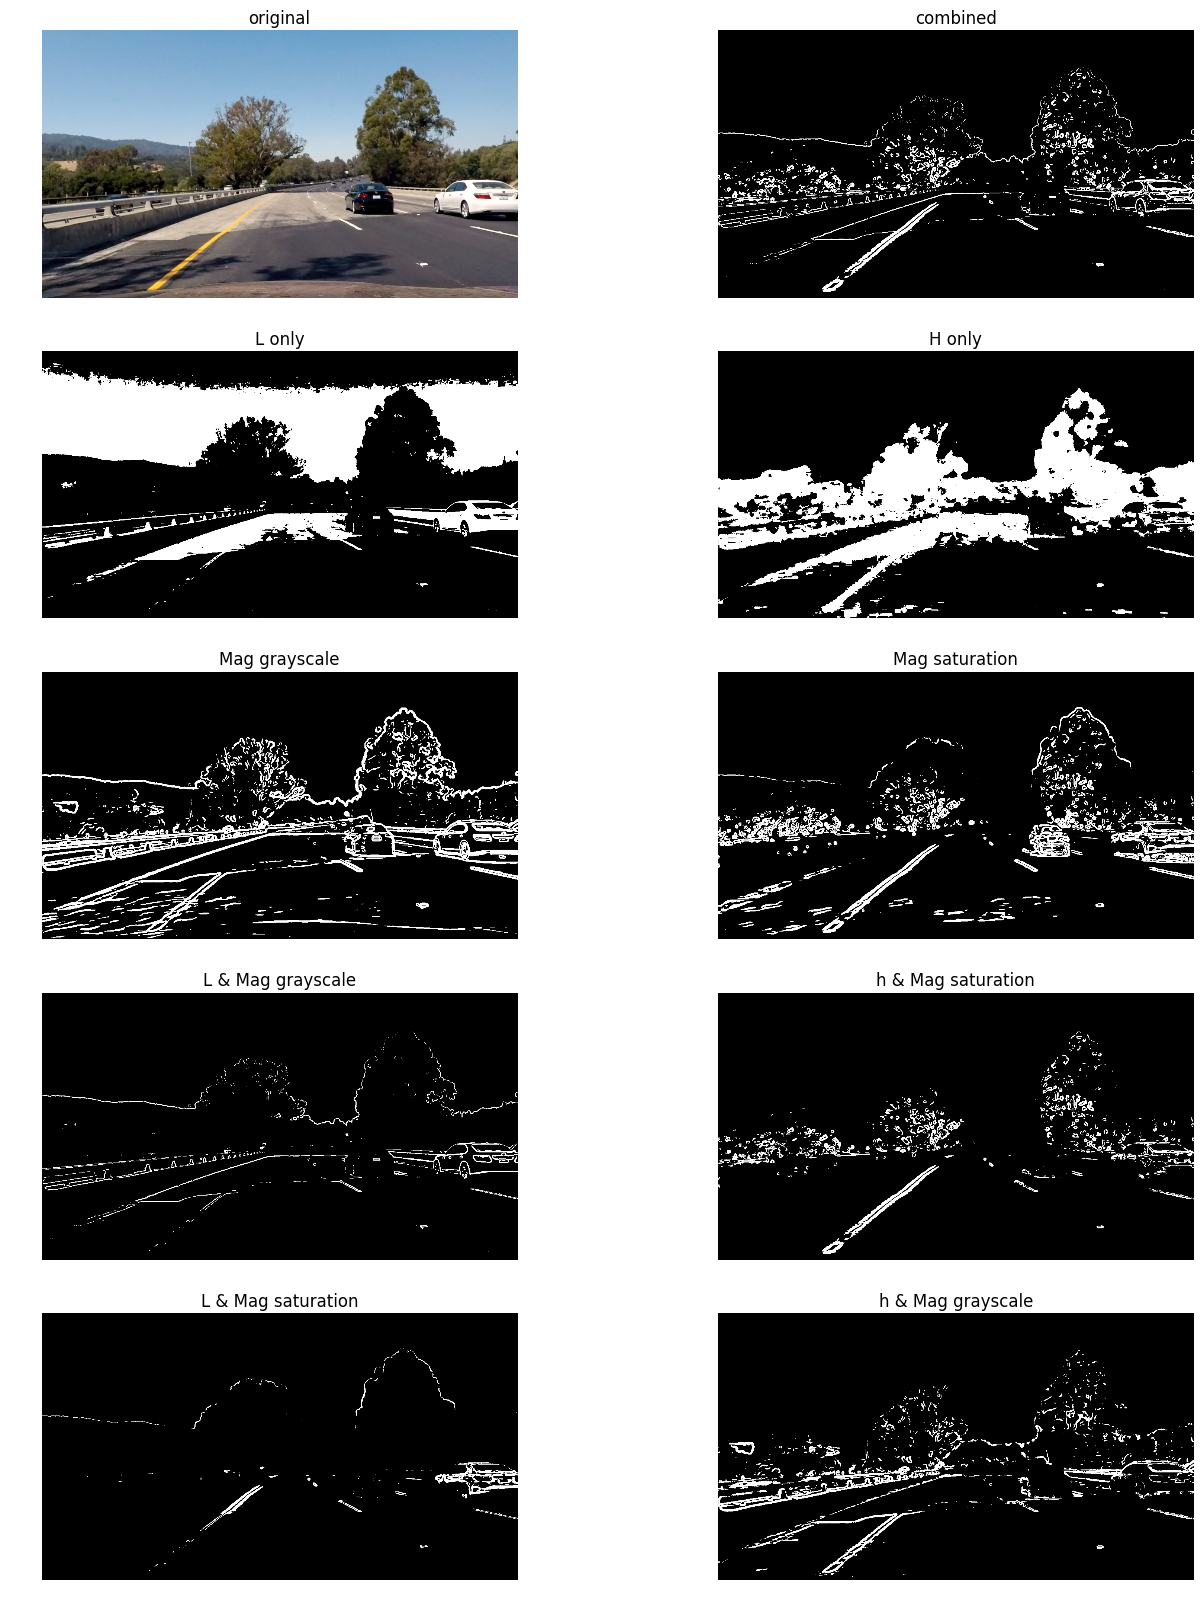

In [9]:
img = mpimg.imread('test_images/test4.jpg')
img = get_undistorted_image(img)
combined, lonly, honly, magdir_gray, l_magdir_gray, magdir_s, h_magdir_s, l_magdir_s, h_magdir_gray = get_thresholded_binary_image(img, True)

_, axarr = plt.subplots(5, 2, figsize=(16, 20))
axarr[0][0].set_title('original')
axarr[0][0].imshow(img)
axarr[0][0].axis('off')

axarr[0][1].set_title('combined')
axarr[0][1].imshow(combined, cmap='gray')
axarr[0][1].axis('off')

axarr[1][0].set_title('L only')
axarr[1][0].imshow(lonly, cmap='gray')
axarr[1][0].axis('off')

axarr[1][1].set_title('H only')
axarr[1][1].imshow(honly, cmap='gray')
axarr[1][1].axis('off')

axarr[2][0].set_title('Mag grayscale')
axarr[2][0].imshow(magdir_gray, cmap='gray')
axarr[2][0].axis('off')

axarr[2][1].set_title('Mag saturation')
axarr[2][1].imshow(magdir_s, cmap='gray')
axarr[2][1].axis('off')

axarr[3][0].set_title('L & Mag grayscale')
axarr[3][0].imshow(l_magdir_gray, cmap='gray')
axarr[3][0].axis('off')

axarr[3][1].set_title('h & Mag saturation')
axarr[3][1].imshow(h_magdir_s, cmap='gray')
axarr[3][1].axis('off')

axarr[4][0].set_title('L & Mag saturation')
axarr[4][0].imshow(l_magdir_s, cmap='gray')
axarr[4][0].axis('off')

axarr[4][1].set_title('h & Mag grayscale')
axarr[4][1].imshow(h_magdir_gray, cmap='gray')
axarr[4][1].axis('off')

# Step 4 -- Birds-eye view

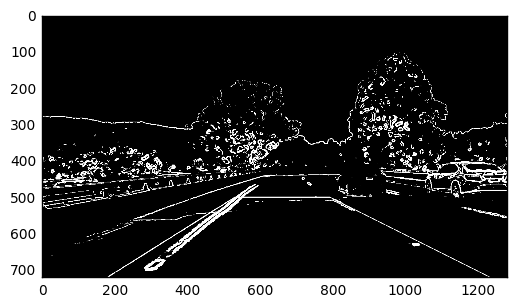

In [10]:
imgpath = 'test_images/test4.jpg'
img = mpimg.imread(imgpath)
img = get_undistorted_image(img)
img = get_thresholded_binary_image(img)

src = np.array([(180, 720), (530, 500), (790, 500), (1230, 720)])
dst = np.array([(180, 720), (180, 0), (1100, 0), (1100, 720)])

cv2.polylines(img, np.array([src]), False, 1, 2)
plt.imshow(img, cmap='gray')

In [11]:
perspectiveTransformMatrix = cv2.getPerspectiveTransform(src.astype(np.float32), dst.astype(np.float32))
perspectiveInverseMatrix = np.linalg.inv(perspectiveTransformMatrix)

def get_perspective_image(img):
    return cv2.warpPerspective(img, perspectiveTransformMatrix, (img.shape[1], img.shape[0]))

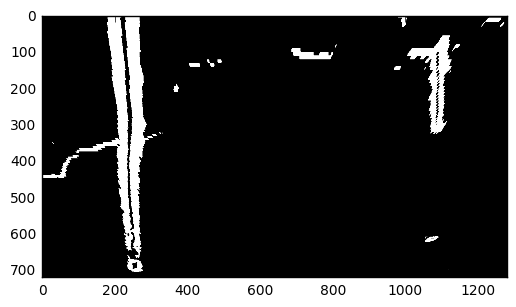

In [12]:
img = mpimg.imread(imgpath)
img = get_undistorted_image(img)
img = get_thresholded_binary_image(img)
img = get_perspective_image(img)
plt.imshow(img, cmap='gray')

# Step 5, 6 -- Detect lane pixels and curvature

In [13]:
class Line():
    
    # Default number for horisontal splits
    N_PARTS = 10
    
    # Blind search params
    SLICE_HIST_MINIMUM_VALUE  = 2   # if peak of local histogram is lower, consider slice as noise
    WINDOW_HIST_MINIMUM_VALUE = 2   # if peak of window histogram is lower, consider window as noise

    WINDOW_SIZE = 70                # half of window width
    RANGE = 100                     # range from central position to detect pixels
    FIRST_SHOT_MINIMAL_PEAK = 30    # for very first window to decide wheither use overall peak or local one
    OVERALL_HIST_DOMINATION_PEAK_VALUE = 200   # amount of pixels to be considered as lane in histogram
    CONFIDENCE_THRESHOLD = .2       # 20% of pixels must be good points to allow polyfit building
    
    # Polifit constants
    #POLIFIT_HIST_THRESHOLD = 1       #30
    
    # For curvature calculations in meters
    CURVATURE_YM_PER_PIX = 30  / 720  # meters per pixel in y dimension
    CURVATURE_XM_PER_PIX = 3.7 / 720  # meteres per pixel in x dimension
    
    # Mesuarements history
    N_HISTORY_SIZE = 10
    
    
    def __init__(self,):
        # Input and output binary images
        self.input_pixels = None
        self.output_pixels = None
        
        # Detection data
        self.detected = False
        self.confidence = 0
        self.start = None
        self.detection_history = []
        
        # Polynomials
        self.polynomial = None
        self.polynomial_history = []
        
        # Curvature
        self.curvature = None
        self.curvature_history = []
        
        # Distance
        self.distance = None
        self.distance_history = []
        
        
    def set_input_pixels(self, input_pixels):
        self.input_pixels = input_pixels
        self.output_pixels = np.zeros_like(self.input_pixels)
        
        self.img_height = self.input_pixels.shape[0]
        self.img_width  = self.input_pixels.shape[1]
        
        self.overall_hist = np.sum(self.input_pixels, axis=0)
        self.overall_hist_value = np.max(self.overall_hist)
        self.overall_peak = np.argmax(self.overall_hist)
        
        self.pixels_per_row = int(self.img_height) // self.N_PARTS
        #print('overall hist value', self.overall_hist_value, 'overall peak', self.overall_peak)

        
    def detect_pixels(self):
        # Define if we need to blind search the starting point or use detected from before
        self.start = None
        last_start = None
        if self.detected == True:
            last_start = self.detection_history[-1]['start']

        for i in range(self.N_PARTS - 1, -1, -1):
            # Define horizontal slice of the image
            row_start, row_end = i * self.pixels_per_row, (i+1) * self.pixels_per_row
            row_slice = self.input_pixels[row_start:row_end,:]
            
            # Get slice histogram
            slice_hist = np.sum(row_slice, axis=0)
            slice_hist_peak_value = np.max(slice_hist)
            slice_hist_peak_position = np.argmax(slice_hist)
            
            # if True, current slice has only noise and should be skipped
            if slice_hist_peak_value < self.SLICE_HIST_MINIMUM_VALUE:
                #print('Skipping slice... [{}-{}]. Slice hist: {}'.format(row_start, row_end, slice_hist_peak_value))
                continue

            # Blind search -- we don't know start position, so use overall and local peaks
            window_center = None
            if last_start is None:
                # If image has big histogram peaks, most probably it is because of straight line on it
                # Use overall peak position since it defines the position of straight line
                if self.overall_hist_value > self.OVERALL_HIST_DOMINATION_PEAK_VALUE:
                    #print('Domination peak... [{}-{}]. Peak value: {}'.format(row_start, row_end, self.overall_peak))
                    window_center = self.overall_peak
                
                # If image has no dominating overall peak, check that local peak of current slice is good enough
                elif slice_hist_peak_value > self.FIRST_SHOT_MINIMAL_PEAK:
                    #print('Slice peak... [{}-{}]. Peak value: {}'.format(row_start, row_end, slice_hist_peak_value))
                    window_center = slice_hist_peak_position
                    
                # Try to find last confident start in the history
                elif len(self.detection_history):
                    for detection in self.detection_history[::-1]:
                        if(detection['confidence'] > self.CONFIDENCE_THRESHOLD):
                            #print('History taken start [{}-{}]. Conf {}'.format(row_start, row_end, detection['confidence']))
                            window_center = detection['start']
                            break
                    
                # If nothing helped and our window center is not found, take overall peak
                # Hopefully the peak is caused because of line pixels there
                if window_center is None:
                    #print('Poor overall peak [{}-{}]'.format(row_start, row_end))
                    window_center = self.overall_peak
            
            # Use last start position as current window center
            else:
                window_center = last_start


            # Define complete window and get its own histogram
            window_start = np.max([0, window_center - self.WINDOW_SIZE])
            window_end = np.min([self.img_width, window_center + self.WINDOW_SIZE])
            window = row_slice[:, window_start:window_end]
            window_hist = np.sum(window, axis=0)
            window_hist_peak_value = np.max(window_hist)
            window_hist_peak_position = np.argmax(window_hist) + window_start
            
            # it is possible that window has only noise
            if window_hist_peak_value < self.WINDOW_HIST_MINIMUM_VALUE:
                #print('Skipping window... [{}-{}]. Slice hist: {}'.format(row_start, row_end, window_hist_peak_value))
                continue

            # Define start as peak position of current window
            start = window_hist_peak_position
            
            # Count all columns of current slice if it has enough hist values and lies within
            # [start-RANGE, start+RANGE]
            col = start
            last_start = start
            mean_hist = np.mean(slice_hist)
            while col >= 0 and col > start - self.RANGE:
                if slice_hist[col] > mean_hist:
                    self.output_pixels[row_start:row_end,col] = row_slice[:,col]
                col -= 1
                
            col = start + 1
            while col < row_slice.shape[1] and col < start + self.RANGE:
                if slice_hist[col] > mean_hist:
                    self.output_pixels[row_start:row_end,col] = row_slice[:,col]
                col += 1
                
            if self.start is None:
                self.start = start
                
        # Reset detected state. If further polynomial building is success, this flag will be set to True
        self.detected = False
        
                
    def build_polynomial(self):
        if self.output_pixels is None:
            raise 'Please detect pixels first'
            
        # Get only nonzero pixels
        nonzeros = np.nonzero(self.output_pixels)
        yvals, xvals = nonzeros[0], nonzeros[1]
        ypoints, xpoints = [], []
        ygood, xgood = [], []
        
        # Reduce points size by leaving only unique Y value and averaged X
        for yuniq in np.unique(yvals):
            subx = xvals[yvals == yuniq]
            #if len(subx) > self.POLIFIT_HIST_THRESHOLD:
            ypoints.append(yuniq)
            xpoints.append(subx.mean())
        
        # Sanity check for points -- need to remove deviations
        xpointsmean = np.array(xpoints).mean()
        xpointsstd  = np.array(xpoints).std()
        for idx in range(len(xpoints)):
            if np.abs(xpoints[idx] - xpointsmean) < xpointsstd * 2:
                xgood.append(xpoints[idx])
                ygood.append(ypoints[idx])
        
        # Confidence is defined as fraction of good points to the maximum possible value of such points
        self.confidence = len(ygood) / float(self.img_height)
        
        # If we have enough points, they'll be used for polyfit
        if self.confidence > self.CONFIDENCE_THRESHOLD or self.polynomial is None:
            self.line_x_points = np.array(xgood)
            self.line_y_points = np.array(ygood)
        
            # Calculate polynomial and save
            polynomial = np.polyfit(self.line_y_points, self.line_x_points, 2)        
            self.polynomial = self.get_smoothed_value(polynomial, self.polynomial_history)
            self.polynomial_history.append(self.polynomial)
            self.polynomial_history = self.polynomial_history[-self.N_HISTORY_SIZE:]
            
            # Line is successfully detected in this frame
            self.detected = True
        
        self.detection_history.append({'start': self.start, 'confidence': self.confidence})
        return self.polynomial
        
        
    def calculate_curvature(self):
        # If this frame is not confident, return last curvature
        if self.confidence < self.CONFIDENCE_THRESHOLD and self.curvature is not None:
            return self.curvature
        
        y_eval = self.input_pixels.shape[0]
        xvals = self.line_x_points * self.CURVATURE_XM_PER_PIX
        yvals = self.line_y_points * self.CURVATURE_YM_PER_PIX
        fit = np.polyfit(yvals, xvals, 2)
        
        # Calculate curvature and save
        curvature = ((1 + (2 * fit[0] * y_eval + fit[1]) ** 2) ** 1.5) / np.absolute(2 * fit[0])
        self.curvature = self.get_smoothed_value(curvature, self.curvature_history)
        self.curvature_history.append(self.curvature)
        self.curvature_history = self.curvature_history[-self.N_HISTORY_SIZE:]
        
        return self.curvature
    
    
    def calculate_distance(self, is_left=True):
        # If this frame is not confident, return last distance
        if self.confidence < self.CONFIDENCE_THRESHOLD and self.distance is not None:
            return self.distance

        mean_lane_points = self.line_x_points.mean()
        if is_left:
            distance = self.img_width - mean_lane_points
        else:
            distance = mean_lane_points
        distance *= self.CURVATURE_XM_PER_PIX
        
        self.distance = self.get_smoothed_value(distance, self.distance_history)
        self.distance_history.append(self.distance)
        self.distance_history = self.distance_history[-self.N_HISTORY_SIZE:]
        
        return self.distance
    
    
    def get_smoothed_value(self, value, history):
        if len(history):
            return np.array(history).mean(axis=0) * .7 + value * .3
        return value

Debugging cell to check polyfit buildings

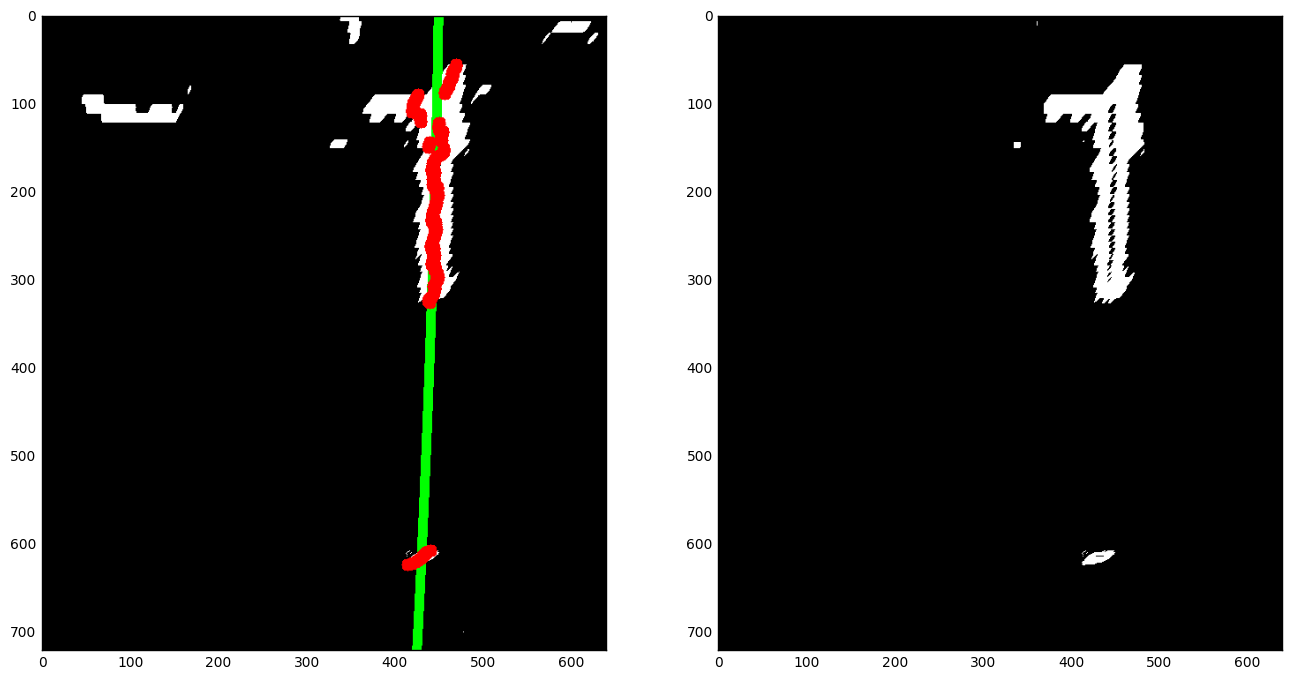

In [14]:
line_left = Line()
line_right = Line()

def fast_process(img):
    # Basic preprocessing
    img_undist = get_undistorted_image(img)
    img_binary = get_thresholded_binary_image(img_undist)
    img_perspective = get_perspective_image(img_binary)
    
    # Line processings
    height = img_perspective.shape[0]
    width = img_perspective.shape[1]
    halfwidth = width // 2
    
#     line_left.set_input_pixels(img_perspective[:,:halfwidth])
#     line_left.detect_pixels()
#     line_left.build_polynomial()
#     line_left.calculate_curvature()
    
    line_right.set_input_pixels(img_perspective[:,halfwidth:])
    line_right.detect_pixels()
    line_right.build_polynomial()
    line_right.calculate_curvature()
    
    # Get polynomials
    yaranged = np.arange(height)
#     fitleft = line_left.polynomial[0] * yaranged ** 2 + line_left.polynomial[1] * yaranged + line_left.polynomial[2]
    fitright = line_right.polynomial[0] * yaranged ** 2 + line_right.polynomial[1] * yaranged + line_right.polynomial[2]
    
#     pts_left = np.array([np.transpose(np.vstack([fitleft, yaranged]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitright + 640, yaranged])))])
    
    perspect = np.copy(img_perspective)
    perspect = np.dstack([perspect, perspect, perspect])
    perspect *= 255
#     cv2.polylines(perspect, np.int_([pts_left]), False, (0, 0, 255), 10)
    cv2.polylines(perspect, np.int_([pts_right]), False, (0, 255, 0), 10)
    for idx in range(len(line_right.line_x_points)):
        cv2.circle(perspect, (int(640 + line_right.line_x_points[idx]), line_right.line_y_points[idx]), 2, (255, 0, 0), 10) 
    
#     plt.imshow(perspect)
    _, axarr = plt.subplots(1, 2, figsize=(16, 10))
    axarr[0].imshow(perspect[:,640:,:])
    axarr[1].imshow(line_right.output_pixels, cmap='gray')
    return None

fast_process(mpimg.imread('test_images/test4.jpg'))

# Step 7,8 Warping back and putting all the pipeline together

In [15]:
def process_image(img):
    # Basic preprocessing
    img_undist = get_undistorted_image(img)
    img_binary = get_thresholded_binary_image(img_undist)
    img_perspective = get_perspective_image(img_binary)
    
    # Line processings
    height = img_perspective.shape[0]
    width = img_perspective.shape[1]
    halfwidth = width // 2
    
    # Process left line
    line_left.set_input_pixels(img_perspective[:,:halfwidth])
    line_left.detect_pixels()
    line_left.build_polynomial()
    line_left.calculate_curvature()
    line_left.calculate_distance()
    
    # Process right line
    line_right.set_input_pixels(img_perspective[:,halfwidth:])
    line_right.detect_pixels()
    line_right.build_polynomial()
    line_right.calculate_curvature()
    line_right.calculate_distance(is_left=False)
    
    # Get polynomials
    yaranged = np.arange(height)
    fitleft = line_left.polynomial[0] * yaranged ** 2 + line_left.polynomial[1] * yaranged + line_left.polynomial[2]
    fitright = line_right.polynomial[0] * yaranged ** 2 + line_right.polynomial[1] * yaranged + line_right.polynomial[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_perspective).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([fitleft, yaranged]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitright + 640, yaranged])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspectiveInverseMatrix, (width, height))
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    # Get images combination to form cute frame with debugging data
    superimage = np.zeros((800, 1920, 3), dtype=np.uint8)
    superimage[0:720, 0:1280, :] = result

    # Binary mask
    binary_resized = cv2.resize(img_binary, (640, 360))
    binary_resized = np.dstack([binary_resized, binary_resized, binary_resized])
    binary_resized *= 255
    superimage[0:360, 1280:, :] = binary_resized

    # Perspective image with drawn polyfits and its points
    perspect = np.copy(img_perspective)
    perspect = np.dstack([perspect, perspect, perspect])
    perspect *= 255
    cv2.polylines(perspect, np.int_([pts_left]), False, (0, 0, 255), 10)
    cv2.polylines(perspect, np.int_([pts_right]), False, (0, 255, 0), 10)
    
    for idx in range(len(line_left.line_x_points)):
        cv2.circle(perspect, (int(line_left.line_x_points[idx]), line_left.line_y_points[idx]), 1, (255, 0, 0), 3) 
    for idx in range(len(line_right.line_x_points)):
        cv2.circle(perspect, (int(640 + line_right.line_x_points[idx]), line_right.line_y_points[idx]), 1, (255, 0, 0), 3) 
    
    perspect = cv2.resize(perspect, (640, 360))
    superimage[360:720, 1280:, :] = perspect

    # Write some texts
    distance_from_center = line_left.distance - line_right.distance
    text = "Left curv: {:.2f} meters   Right curv: {:.2f} meters  Distance from center: {:.2f} meters".format(
        line_left.curvature, line_right.curvature, distance_from_center
    )
    cv2.putText(superimage, text, (20, 770), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    return superimage

## Playing with test images

Another testing cell to see how all-together picture looks like

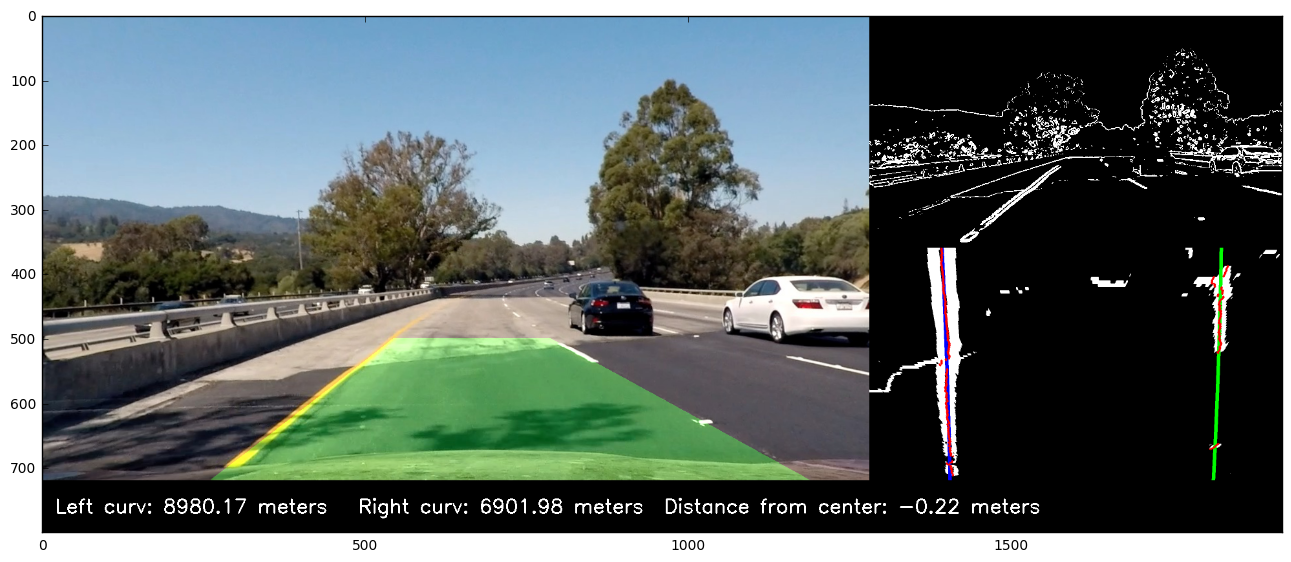

In [16]:
line_left = Line()
line_right = Line()

img = mpimg.imread('test_images/test4.jpg')
plt.figure(figsize=(16, 10))
plt.imshow(process_image(img))

## Video processing

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
!mkdir output_videos -p

In [19]:
line_left = Line()
line_right = Line()

white_output = 'output_videos/project.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project.mp4
[MoviePy] Writing video output_videos/project.mp4


100%|█████████▉| 1260/1261 [08:10<00:00,  2.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project.mp4 



In [20]:
line_left = Line()
line_right = Line()

white_output = 'output_videos/challenge.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge.mp4
[MoviePy] Writing video output_videos/challenge.mp4


100%|██████████| 485/485 [03:05<00:00,  2.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge.mp4 



In [21]:
line_left = Line()
line_right = Line()

white_output = 'output_videos/harder_challenge.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge.mp4
[MoviePy] Writing video output_videos/harder_challenge.mp4


100%|█████████▉| 1199/1200 [07:42<00:00,  2.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge.mp4 

